<ipython-input-9-f9b2a9d5b9e6>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').mean().interpolate()


Prompt: Given the memory usage sequence: 1 2 2 1 3 2 2 2 2 3 2 1 1 0 0 92 95 94 95 92 93 90 92 89, predict the next 10 values.
Expected: 92 93 93 91 94 93 92 91 92 92
Predicted: 92 89 92 89 92 89 92 89 92 89


<ipython-input-9-f9b2a9d5b9e6>:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pred_times = pd.date_range(start=pred_start, periods=prediction_horizon, freq='H')


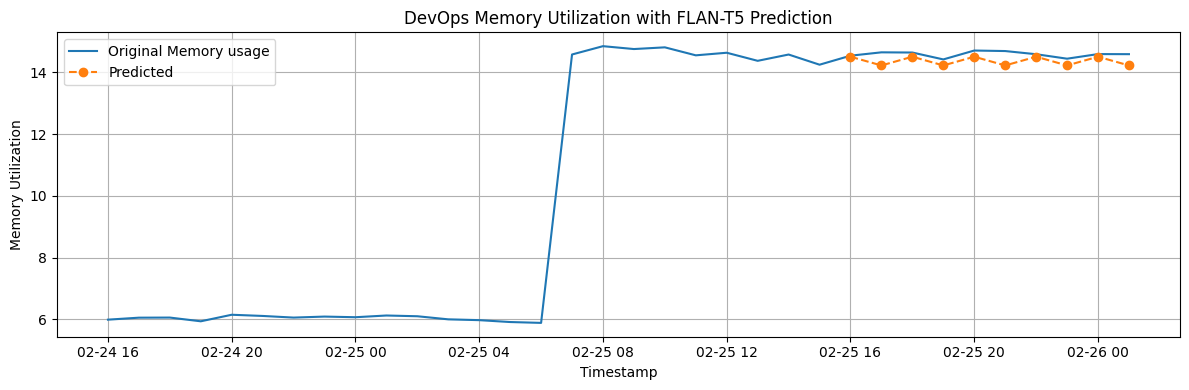

In [9]:
# FLAN-T5 Time Series Forecasting for DevOps Dataset

# Install dependencies
!pip install -q transformers pandas matplotlib scikit-learn

# Import libraries
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random

# Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Load DevOps dataset (example: Azure VM memory usage)
df = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.rename(columns={df.columns[0]: 'value'})
df = df.resample('1H').mean().interpolate()

# Normalize values for consistent token mapping
scaler = MinMaxScaler(feature_range=(0, 100))
df['normalized'] = scaler.fit_transform(df[['value']])

# Quantize the series to discrete tokens
def quantize_series(series, bins):
    quantized = pd.cut(series, bins=bins, labels=False)
    return list(quantized.astype(int))

# Parameters
context_window = 24
prediction_horizon = 10
bins = 100

# Generate examples for prompting
examples = []
quantized_values = quantize_series(df['normalized'], bins)

for i in range(len(quantized_values) - context_window - prediction_horizon):
    input_seq = quantized_values[i:i+context_window]
    output_seq = quantized_values[i+context_window:i+context_window+prediction_horizon]
    prompt = f"Given the memory usage sequence: {' '.join(map(str, input_seq))}, predict the next {prediction_horizon} values."
    target = ' '.join(map(str, output_seq))
    examples.append((i, input_seq, prompt, target))

# Pick a random example for demonstration
sample_index, input_seq, sample_prompt, expected = random.choice(examples)
print("Prompt:", sample_prompt)
print("Expected:", expected)

# Generate prediction
inputs = tokenizer(sample_prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=20)
predicted = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Predicted:", predicted)

# Decode prediction back to values
try:
    predicted_tokens = list(map(int, predicted.strip().split()))
    predicted_vals = scaler.inverse_transform(np.array(predicted_tokens).reshape(-1, 1))
except:
    predicted_tokens = []
    predicted_vals = []

# Plot original + prediction
start_index = sample_index  # anchor to actual sample used
end_index = start_index + context_window + prediction_horizon
pred_start = df.index[start_index + context_window]
pred_times = pd.date_range(start=pred_start, periods=prediction_horizon, freq='H')

plt.figure(figsize=(12, 4))
plt.plot(df.index[start_index:end_index], df['value'][start_index:end_index], label='Original Memory usage')
if len(predicted_vals) == prediction_horizon:
    plt.plot(pred_times, predicted_vals, label='Predicted', marker='o', linestyle='--')
plt.title("DevOps Memory Utilization with FLAN-T5 Prediction")
plt.xlabel("Timestamp")
plt.ylabel("Memory Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
